In [2]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary
import numpy as np
import pandas as pd

### 算预期销售量

In [3]:
crop_plant = pd.read_excel('附件2.xlsx', sheet_name='2023年的农作物种植情况')
crop_plant = crop_plant.groupby(['地块类型', '种植季次', '作物名称']).agg({
    '作物类型': 'first',
    '种植面积/亩': 'sum'  # 按地块类型、作物名称和种植季次求种植面积之和
}).reset_index()  # 注意要reset_index，确保groupby后的结果可以正确使用
crop_plant

,地块类型,种植季次,作物名称,作物类型,种植面积/亩
0,山坡地,单季,南瓜,粮食,13.0
1,山坡地,单季,小麦,粮食,27.0
2,山坡地,单季,红薯,粮食,18.0
3,山坡地,单季,红豆,粮食（豆类）,20.0
4,山坡地,单季,荞麦,粮食,15.0
...,...,...,...,...,...
59,水浇地,第一季,西红柿,蔬菜,14.0
60,水浇地,第一季,豇豆,蔬菜（豆类）,10.0
61,水浇地,第二季,大白菜,蔬菜,30.0
62,水浇地,第二季,白萝卜,蔬菜,25.0


In [4]:
crop_yield = pd.read_excel('附件2.xlsx', sheet_name='2023年统计的相关数据')
crop_yield.drop(columns=['min', 'max'], inplace=True)
crop_yield = crop_yield[:107]
crop_yield

,序号,作物编号,作物名称,地块类型,种植季次,亩产量/斤,种植成本/(元/亩),销售单价/(元/斤),销售单价均值
0,1,1,黄豆,平旱地,单季,400.0,400.0,2.50-4.00,3.25
1,2,2,黑豆,平旱地,单季,500.0,400.0,6.50-8.50,7.50
2,3,3,红豆,平旱地,单季,400.0,350.0,7.50-9.00,8.25
3,4,4,绿豆,平旱地,单季,350.0,350.0,6.00-8.00,7.00
4,5,5,爬豆,平旱地,单季,415.0,350.0,6.00-7.50,6.75
...,...,...,...,...,...,...,...,...,...
102,103,30,生菜,智慧大棚,第二季,4500.0,2200.0,5.40-7.20,6.30
103,104,31,辣椒,智慧大棚,第二季,1800.0,1300.0,7.20-10.20,8.70
104,105,32,空心菜,智慧大棚,第二季,11000.0,5500.0,3.60-7.20,5.40
105,106,33,黄心菜,智慧大棚,第二季,5400.0,2750.0,4.80-6.00,5.40


In [5]:
merge_df = crop_yield.merge(crop_plant, on=['作物名称', '地块类型', '种植季次'], how='left')
## 填充0到种植面积空值
merge_df['种植面积/亩'] = merge_df['种植面积/亩'].fillna(0)
merge_df['总产量'] = merge_df['亩产量/斤'] * merge_df['种植面积/亩']
merge_df

expect_sell = merge_df.groupby(['作物名称', '种植季次']).agg({
    '作物编号': 'first',
    '作物类型': 'first',
    '总产量': 'sum'
}).reset_index()
expect_sell.sort_values(by=['作物编号','种植季次'], ascending=True, inplace=True)
# drop掉总产量为0的行
# expect_sell = expect_sell[expect_sell['总产量'] != 0]
expect_sell.reset_index(inplace=True, drop=True)
expect_sell

# expect_sell.to_csv('预期销售量.csv', index=False)

,作物名称,种植季次,作物编号,作物类型,总产量
0,黄豆,单季,1,粮食（豆类）,57000.0
1,黑豆,单季,2,粮食（豆类）,21850.0
2,红豆,单季,3,粮食（豆类）,22400.0
3,绿豆,单季,4,粮食（豆类）,33040.0
4,爬豆,单季,5,粮食（豆类）,9875.0
5,小麦,单季,6,粮食,170840.0
6,玉米,单季,7,粮食,132750.0
7,谷子,单季,8,粮食,71400.0
8,高粱,单季,9,粮食,30000.0
9,黍子,单季,10,粮食,12500.0


### 画图

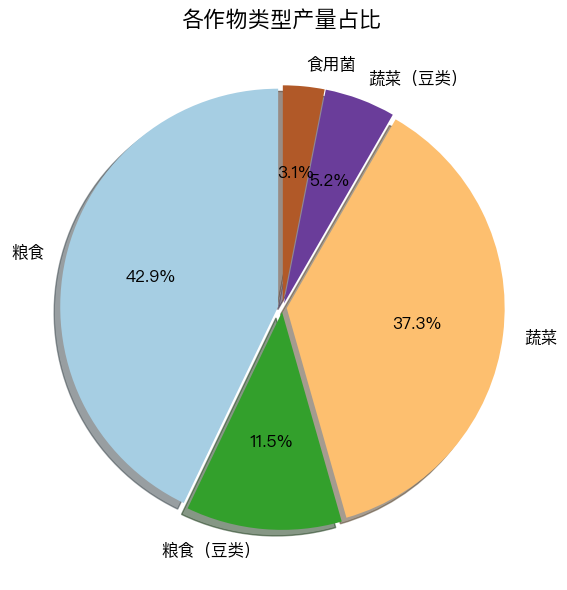

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter

# 设置中文字体
font = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')  # 指定字体路径
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# # 创建饼图
# plt.pie(expect_sell['总产量'], labels=expect_sell['作物编号'], autopct='%1.1f%%')
# plt.title(f"各作物产量占比", fontproperties=font)
# plt.show()

# 处理数据，保留总产量大于0的部分
data_to_plot = expect_sell[expect_sell['总产量'] > 0]
data_to_plot = data_to_plot.groupby('作物类型').agg({'总产量': 'sum'}).reset_index()

# 创建饼图，增加美化效果
fig = plt.figure(figsize=(6,6),dpi=100)

colors = plt.cm.Paired(np.linspace(0, 1, len(data_to_plot)))  # 使用颜色映射生成一组颜色
explode = [0.02] * len(data_to_plot)  # 让每个扇形稍微突出

plt.pie(data_to_plot['总产量'], 
        labels=data_to_plot['作物类型'], 
        autopct='%1.1f%%', 
        textprops={'fontproperties': font, 'fontsize': 12},  # 设置字体大小
        startangle=90,  # 使饼图从正上方开始
        colors=colors,  # 设置颜色
        explode=explode,  # 让扇区稍微突出
        shadow=True)  # 增加阴影效果

# 设置标题
plt.title("各作物类型产量占比", fontproperties=font, fontsize=16)

# 显示图形
plt.tight_layout()
plt.show()

### 处理数据

In [7]:
info = pd.read_excel('附件1.xlsx', sheet_name='乡村的现有耕地')
info = info[['地块名称', '地块类型编号','地块类型', '地块面积/亩']]

## 1.地块面积 （54,1）
S = info['地块面积/亩'].to_numpy()
S

## 2.销售单价（41,16）
p0 = crop_yield[['作物编号', '种植季次', '销售单价均值']]
p0.loc[p0['种植季次'] == '单季', '种植季次'] = '第一季'  # 把种植季次为单季的改为第一季
# 创建透视表，以 '作物编号' 作为行索引，'种植季次' 作为列
p0 = p0.pivot_table(index='作物编号', columns='种植季次', values='销售单价均值')
p0 = p0.fillna(0)  # 填充缺失值为 0
# 重置列标题名称
p0.columns = ['1', '2']

# 获取第 1 列和第 2 列的值
col_1 = p0['1'].values
col_2 = p0['2'].values
# 创建一个空的数组用于存储 14 列的值
expanded_p = np.zeros((p0.shape[0], 16))
# 每个奇数列放 col_1，每个偶数列放 col_2
expanded_p[:, ::2] = col_1[:, np.newaxis]  # 奇数列 (1, 3, 5, ...)
expanded_p[:, 1::2] = col_2[:, np.newaxis]  # 偶数列 (2, 4, 6, ...)

# # 创建二维字典 p
# p = {}

# # 遍历二维数组，构建字典
# for i in range(expanded_p.shape[0]):  # 遍历每一行
#     p[i] = {}
#     for j in range(expanded_p.shape[1]):  # 遍历每一列
#         p[i][j] = expanded_p[i, j]
# p
expanded_p.shape

(41, 16)

In [8]:
## 3.预期销售量（41,16）
D0 = expect_sell[['作物编号', '种植季次', '总产量']]
D0.loc[D0['种植季次'] == '单季', '种植季次'] = '第一季'  # 把种植季次为单季的改为第一季
D0 = D0.pivot_table(index='作物编号', columns='种植季次', values='总产量', aggfunc='sum')
D0 = D0.fillna(0)  # 填充缺失值为 0
D0.columns = ['1', '2']

# 获取第 1 列和第 2 列的值
col_1 = D0['1'].values
col_2 = D0['2'].values
# 创建一个空的数组用于存储 14 列的值
expanded_D = np.zeros((D0.shape[0], 16))
# 每个奇数列放 col_1，每个偶数列放 col_2
expanded_D[:, ::2] = col_1[:, np.newaxis]  # 奇数列 (1, 3, 5, ...)
expanded_D[:, 1::2] = col_2[:, np.newaxis]  # 偶数列 (2, 4, 6, ...)

# # 创建二维字典 D
# D = {}

# # 遍历二维数组，构建字典
# for i in range(expanded_D.shape[0]):  # 遍历每一行
#     D[i] = {}
#     for j in range(expanded_D.shape[1]):  # 遍历每一列
#         D[i][j] = expanded_D[i, j]
# D
expanded_D.shape

(41, 16)

In [9]:
## 4.亩产量( 54，41)
crop_yield.loc[crop_yield['种植季次'] == '单季', '种植季次'] = '第一季'  # 把种植季次为单季的改为第一季
Q0 = crop_yield[['作物编号', '地块类型','种植季次', '亩产量/斤']]
## 把地块类型“平旱地”改为A，“梯田”改为B， “山坡地“改为C，“水浇地”改为D， 普通大棚为E，智慧大棚为F
Q0.loc[Q0['地块类型'] == '平旱地', '地块类型'] = 'A'
Q0.loc[Q0['地块类型'] == '梯田', '地块类型'] = 'B'
Q0.loc[Q0['地块类型'] == '山坡地', '地块类型'] = 'C'
Q0.loc[Q0['地块类型'] == '水浇地', '地块类型'] = 'D'
Q0.loc[Q0['地块类型'] == '普通大棚', '地块类型'] = 'E'
Q0.loc[Q0['地块类型'] == '智慧大棚', '地块类型'] = 'F'

Q0 = info.drop(columns=['地块类型']).merge(Q0, left_on='地块类型编号', right_on='地块类型', how='left')
Q0 = Q0.drop(columns=['地块类型编号', '地块类型', '地块面积/亩'])
# Q0 = Q0.pivot_table(index='地块名称', columns='作物编号', values='亩产量/斤', aggfunc='sum')
# Q0 = Q0.fillna(0)  # 填充缺失值为 0
# # Q0.values

Q0['地块名称'] = Q0['地块名称'].astype('category').cat.codes  # 将地块名称映射为编号
# Q0['种植季次'] = Q0['种植季次'].map({'第一季': 0, '第二季': 1})  # 将种植季次映射为 0 和 1
# 创建一个形状为 (地块数, 作物编号数, 季次数) 的三维数组
num_plots = len(Q0['地块名称'].unique())  # 地块数量
num_crops = len(Q0['作物编号'].unique())  # 作物编号数量
num_seasons = len(Q0['种植季次'].unique())  # 季次数量
# 初始化三维数组，设置默认值为 0
Q = np.zeros((num_plots, num_crops, num_seasons))

season_mapping = {'第一季': 0, '第二季': 1}
# 遍历 DataFrame Q，填充三维数组 arr
for _, row in Q0.iterrows():
    i = int(row['地块名称']) - 1  # 地块名称的索引（从0开始）
    j = int(row['作物编号']) - 1    # 作物编号的索引（从0开始）
    k = season_mapping.get(row['种植季次'], None)  # 获取种植季次的索引

    if k is not None:
        Q[i, j, k] = row['亩产量/斤']

expanded_Q = np.empty((54,41, 16))
# 填充新数组
expanded_Q[:, :, 0::2] = Q[:, :, 0][:, :, np.newaxis]  # 奇数层（0, 2, 4, ..., 14）
expanded_Q[:, :, 1::2] = Q[:, :, 1][:, :, np.newaxis]  # 偶数层（1, 3, 5, ..., 15）
# 打印结果形状和示例值
print(expanded_Q.shape)  # 输出应为 (54, 41, 16)
expanded_Q

# # 转换成字典
# dict_Q = {}

# # 遍历三维数组，构建字典
# for i in range(expanded_Q.shape[0]):  # 6
#     dict_Q[i] = {}
#     for j in range(expanded_Q.shape[1]):  # 10
#         dict_Q[i][j] = {}
#         for k in range(expanded_Q.shape[2]):  # 16
#             dict_Q[i][j][k] = expanded_Q[i, j, k]

# dict_Q

(54, 41, 16)


array([[[400.,   0., 400., ...,   0., 400.,   0.],
        [500.,   0., 500., ...,   0., 500.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[400.,   0., 400., ...,   0., 400.,   0.],
        [500.,   0., 500., ...,   0., 500.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[400.,   0., 400., ...,   0., 400.,   0.],
        [500.,   0., 500., ...,   0., 500.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0

In [10]:
## 5.成本 54,41
C0 = crop_yield[['作物编号', '地块类型','种植季次', '种植成本/(元/亩)']]
## 把地块类型“平旱地”改为A，“梯田”改为B， “山坡地“改为C，“水浇地”改为D， 普通大棚为E，智慧大棚为F
C0.loc[C0['地块类型'] == '平旱地', '地块类型'] = 'A'
C0.loc[C0['地块类型'] == '梯田', '地块类型'] = 'B'
C0.loc[C0['地块类型'] == '山坡地', '地块类型'] = 'C'
C0.loc[C0['地块类型'] == '水浇地', '地块类型'] = 'D'
C0.loc[C0['地块类型'] == '普通大棚', '地块类型'] = 'E'
C0.loc[C0['地块类型'] == '智慧大棚', '地块类型'] = 'F'

C0 = info.drop(columns=['地块类型']).merge(C0, left_on='地块类型编号', right_on='地块类型', how='left')
C0 = C0.drop(columns=['地块类型编号', '地块类型', '地块面积/亩'])
# C0 = C0.pivot_table(index='地块名称', columns='作物编号', values='种植成本/(元/亩)', aggfunc='sum')
# C0 = C0.fillna(0)  # 填充缺失值为 0
# C0.values

C0['地块名称'] = C0['地块名称'].astype('category').cat.codes  # 将地块名称映射为编号
# 创建一个形状为 (地块数, 作物编号数, 季次数) 的三维数组
num_plots = len(C0['地块名称'].unique())  # 地块数量
num_crops = len(C0['作物编号'].unique())  # 作物编号数量
num_seasons = len(C0['种植季次'].unique())  # 季次数量
# 初始化三维数组，设置默认值为 0
C = np.zeros((num_plots, num_crops, num_seasons))

season_mapping = {'第一季': 0, '第二季': 1}
# 遍历 DataFrame Q，填充三维数组 arr
for _, row in C0.iterrows():
    i = int(row['地块名称']) - 1  # 地块名称的索引（从0开始）
    j = int(row['作物编号']) - 1    # 作物编号的索引（从0开始）
    k = season_mapping.get(row['种植季次'], None)  # 获取种植季次的索引

    if k is not None:
        C[i, j, k] = row['种植成本/(元/亩)']

expanded_C = np.empty((54,41, 16))
# 填充新数组
expanded_C[:, :, 0::2] = C[:, :, 0][:, :, np.newaxis]  # 奇数层（0, 2, 4, ..., 14）
expanded_C[:, :, 1::2] = C[:, :, 1][:, :, np.newaxis]  # 偶数层（1, 3, 5, ..., 15）
# 打印结果形状和示例值
print(expanded_C.shape)  # 输出应为 (54, 41, 16)
expanded_C

# # 转换成字典
# dict_C = {}

# # 遍历三维数组，构建字典
# for i in range(expanded_Q.shape[0]):  # 6
#     dict_C[i] = {}
#     for j in range(expanded_Q.shape[1]):  # 10
#         dict_C[i][j] = {}
#         for k in range(expanded_Q.shape[2]):  # 16
#             dict_C[i][j][k] = expanded_Q[i, j, k]

# dict_C

(54, 41, 16)


array([[[400.,   0., 400., ...,   0., 400.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        [350.,   0., 350., ...,   0., 350.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[400.,   0., 400., ...,   0., 400.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        [350.,   0., 350., ...,   0., 350.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       [[400.,   0., 400., ...,   0., 400.,   0.],
        [400.,   0., 400., ...,   0., 400.,   0.],
        [350.,   0., 350., ...,   0., 350.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0

In [11]:
from pulp import *
import random
import itertools

# 创建两个模型
model_no_discount = LpProblem("Maximize_Profit_No_Discount", LpMaximize)
model_with_discount = LpProblem("Maximize_Profit_With_Discount", LpMaximize)

# 定义范围和规模
num_i = 54  # 地块数目
num_j = 41  # 作物种类数目
num_t = 16  # 季节数目

# 定义离散索引范围
i_range = range(0, num_i)  # 共有54块地
j_range = range(0, num_j)  # 共有41种作物
t_range = range(0, num_t)  # 共有16季

# 定义决策变量
X = LpVariable.dicts("X", (i_range, j_range, t_range), lowBound=0, cat='Continuous')
Y = LpVariable.dicts("Y", (i_range, j_range, t_range), cat=LpBinary)
# 专用于水浇地的二元变量
z = LpVariable.dicts("z", (i_range, t_range), cat='Binary')

p = expanded_p
D = expanded_D
c = expanded_C
q = expanded_Q

# 定义不确定性参数
# 假设我们有对销售量、亩产量、种植成本和销售价格的不确定性
# 这里的范围仅供参考，实际值需从数据中得出
alpha = 0.05  # 销售量变化幅度
beta = 0.10  # 亩产量变化幅度
gamma = 0.05  # 种植成本增长幅度

# 定义不确定性的范围，使用嵌套的 for 循环
# 销售量 D_robust
# 玉米、小麦 [0.05, 0.1]
for j in range(5, 7):
    # dt = generate_random_list(16, 0.05, 0.1)
    dt = np.random.uniform(0.05, 0.1, 16)
    for t in range(0, 16, 2):  # 处理第一季数据
        D[j][t] = D[j][t] * (1 + dt[t]) ** (t / 2)
    for t in range(1, 16, 2):  # 处理第二季数据
        D[j][t] = D[j][t] * (1 + dt[t]) ** ((t - 1) / 2)
# 其他农作物 [-0.05, 0.05]
for j in itertools.chain(range(0,5), range(7,41)):
    # dt = generate_random_list(16, 0.05, 0.1)
    dt = np.random.uniform(-0.05, 0.05, 16)
    for t in range(0,16): # 处理季数据（第一季）
        D[j][t] = D[j][t] * (1 - dt[t])


# 亩产量 q_robust [-0.1, 0.1]
for i in i_range:
    # qt = generate_random_list(16, -0.1, 0.1)
    qt = np.random.uniform(-0.1, 0.1, 16)
    for j in j_range:
        for t in range(0, 16, 2):  # 第一季
            q[i][j][t] = q[i][j][t] * (1 - qt[t]) ** (t / 2)
        for t in range(1, 16, 2):  # 第二季
            q[i][j][t] = q[i][j][t] * (1 - qt[t]) ** ((t - 1) / 2)

# 种植成本 c_robust 0.05
for i in i_range:
    for j in j_range:
        for t in range(0,16,2):
            c[i][j][t] = c[i][j][t] * (1 + gamma) ** (t/2)
        for t in range(1,16,2):
            c[i][j][t] = c[i][j][t] * (1 + gamma) ** ((t-1)/2)

# 蔬菜类作物 每年增长5%
for j in range(16, 37):
    for t in range(0,16,2):
        p[j][t] = p[j][t] * (1 + 0.05) ** (t/2)
    for t in range(1,16,2):
        p[j][t] = p[j][t] * (1 + 0.05) ** ((t-1)/2)
# 食用菌每年下降1%～5%(除羊肚菌外）
for j in range(37, 40):
    # pt = generate_random_list(16, -0.05, -0.01)
    pt = np.random.uniform(-0.05, -0.01, 16)
    for t in range(0,16,2):
        p[j][t] = p[j][t] * (1 - pt[t]) ** (t/2)
    for t in range(1,16,2):
        p[j][t] = p[j][t] * (1 - pt[t]) ** ((t-1)/2)
# 羊肚菌 -0.05
for t in range(0,16,2):
    p[40][t] = p[j][t] * (1 -0.05) ** (t/2)
for t in range(1,16,2):
    p[40][t] = p[j][t] * (1 -0.05) ** ((t-1)/2)

In [12]:
# 计算总产量
# Q = {j: {t: lpSum(X[i][j][t] * q[i][j][t] for i in i_range) for t in t_range} for j in j_range}

# 添加约束和目标函数
def add_constraints_and_objective(prob, discount=False):
    # 定义新变量来表示 min 和 max 操作
    min_vars = LpVariable.dicts("min_vars", (j_range, t_range), lowBound=0, cat='Continuous')
    max_vars = LpVariable.dicts("max_vars", (j_range, t_range), lowBound=0, cat='Continuous')
    Q = LpVariable.dicts("Q", (j_range, t_range), lowBound=0, cat="Continuous")
    for j in j_range:
        for t in t_range:
            prob += Q[j][t] == lpSum(X[i][j][t] * q[i][j][t] for i in i_range)

    # 添加 min 和 max 操作约束
    for j in j_range:
        for t in t_range:
            prob += min_vars[j][t] >= 0
            prob += min_vars[j][t] <= Q[j][t]
            prob += min_vars[j][t] <= D[j][t]

            prob += max_vars[j][t] >= 0
            prob += max_vars[j][t] >= Q[j][t] - D[j][t]
            prob += max_vars[j][t] <= Q[j][t]
    
    # 添加目标函数
    if discount:
        prob += lpSum(p[j][t] * min_vars[j][t] + 
                      0.5 * p[j][t] * max_vars[j][t] - 
                      lpSum(c[i][j][t] * X[i][j][t] for i in i_range)
                      for j in j_range for t in t_range)
    else:
        prob += lpSum(p[j][t] * min_vars[j][t] - 
                      lpSum(c[i][j][t] * X[i][j][t] for i in i_range)
                      for j in j_range for t in t_range)
        
    # # 目标函数
    # if discount:
    #     prob += lpSum(p[j][t] * min(Q[j][t], D[j][t]) + 
    #                   0.5 * p[j][t] * max(Q[j][t] - D[j][t], 0) - 
    #                   c[i][j][t] * X[i][j][t] 
    #                   for i in i_range for j in j_range for t in t_range)
    # else:
    #     prob += lpSum(p[j][t] * min(Q[j][t], D[j][t]) - 
    #                   c[i][j][t] * X[i][j][t] 
    #                   for i in i_range for j in j_range for t in t_range)

    # 1. 耕地面积限制：种植面积不能超过地块面积
    for i in i_range:
        for t in t_range:
            prob += lpSum(X[i][j][t] for j in j_range) <= S[i]
    
    # 2. 种植条件: 作物和地块种植类型限制
    # 对于平旱地，梯田，山坡地：
    for i in range(0, 26):
        for j in range(15,41):
            for t in t_range:
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
    # 对于水浇地
    # 两季都不能种的作物
    for i in range(26, 35):
        for j in itertools.chain(range(0, 15), range(37, 41)):
            for t in t_range:
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
        # 第一季不能种的作物
        for j in range(34, 37):
            for t in range(0, 16, 2):
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
        # 第二季不能种的作物
        for j in range(15, 34):
            for t in range(1, 16, 2):
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
    # 对于普通大棚
    # 两季都不能种的作物
    for i in range(34,50):
        for j in itertools.chain(range(0, 16), range(34, 37)):
            for t in t_range:
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
        # 第一季不能种的作物
        for j in range(37,41):
            for t in range(0,16,2):
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
        # 第二季不能种的作物
        for j in range(16,34):
            for t in range(1,16,2):
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
    # 对于智慧大棚
    # 两季都不能种的作物
    for i in range(50,54):
        for j in itertools.chain(range(0,16), range(34,41)):
            for t in t_range:
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
    
    # 3. 农作物轮作
    # 对于平旱地，梯田，山坡地的情况
    for i in range(0,27):
        for j in range(0,15):
            for t in range(1, 16, 2):  # 假设每年种植周期为2
                prob += X[i][j][t] == 0
                prob += Y[i][j][t] == 0
            for t in range(0, 14, 2):
                prob += Y[i][j][t] + Y[i][j][t+2] <= 1
    # 对于水浇地的情况:
    # 不能重茬
    M = 1e6
    for i in range(27, 34):
        for t in range(1, 16, 2):
            prob += X[i][15][t] ==0
            prob += Y[i][15][t] ==0
        for t in range(0, 14, 2):
            prob += Y[i][15][t] + Y[i][15][t+2] <= 1
        # 只能单季水稻或两季蔬菜：
        # 单季水稻与两季蔬菜的互斥约束
        for t in range(0, 16, 2):
            prob += Y[i][15][t] + Y[i][15][t+1] <= M * z[i][t]
            prob += lpSum(Y[i][j][t] for j in range(16, 34)) + lpSum(Y[i][j][t+1] for j in range(34, 37)) <= M * (1 - z[i][t])
            prob += z[i][t] <= 1  # This ensures that z is either 0 or 1

    # 对于智慧大棚的情况：
    # 不能重茬
    for i in range(50,54):
        for j in range(16,34):
            for t in range(0,15):
                prob += Y[i][j][t] + Y[i][j][t+1] <= 1
                
    # 4. 豆类作物种植
    for i in i_range:
        for t in range(5, 16):
            prob += lpSum(Y[i][j][t-5] + Y[i][j][t-4] + Y[i][j][t-3] + Y[i][j][t-2] + Y[i][j][t-1] + Y[i][j][t] for j in bean_crops) >= 1

    # 5. 作物种植面积分配
    M = 1e6  # 大常数，应该大于 X[i][j][t] 的可能最大值
    for i in i_range:
        for j in j_range:
            for t in t_range:
                # prob += X[i][j][t] * (0.5 * S[i] - X[i][j][t]) <= 0
                prob += X[i][j][t] <= M * Y[i][j][t]
                prob += X[i][j][t] >= 0

# 假设豆类作物的索引
bean_crops = [0, 1, 2, 3, 4, 16, 17, 18]

# 添加约束和目标函数
add_constraints_and_objective(model_no_discount, discount=False)
add_constraints_and_objective(model_with_discount, discount=True)

# 求解模型
# model_no_discount.solve(pulp.PULP_CBC_CMD(timelimit=180))
# model_with_discount.solve()
model_no_discount.solve(pulp.PULP_CBC_CMD(timeLimit=180))

# 打印结果
print("Optimal Solution for No Discount:")
for v in model_no_discount.variables():
    if v.varValue > 0:
        print(v.name, "=", v.varValue)

# print("\nOptimal Solution for With Discount:")
# for v in model_with_discount.variables():
#     if v.varValue > 0:
#         print(v.name, "=", v.varValue)
        
# 打印目标函数总利润
print("\nTotal Profit for No Discount:")
print("Objective Value =", value(model_no_discount.objective))

# print("\nTotal Profit for With Discount:")
# print("Objective Value =", value(model_with_discount.objective))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/keen/anaconda3/envs/learningbase/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r_/qtqd891j2xlg8p97d2rvvdcm0000gn/T/2c6dca3142c345d7931c1b2c782d9750-pulp.mps -max -sec 180 -timeMode elapsed -branch -printingOptions all -solution /var/folders/r_/qtqd891j2xlg8p97d2rvvdcm0000gn/T/2c6dca3142c345d7931c1b2c782d9750-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 136203 COLUMNS
At line 464796 RHS
At line 600995 BOUNDS
At line 636476 ENDATA
Problem MODEL has 136198 rows, 72872 columns and 249240 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 180
Option for timeMode changed from cpu to elapsed
Continuous objective value is 4.85543e+07 - 0.19 seconds
Cgl0002I 26960 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 73 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened ro

In [13]:
import pandas as pd
from openpyxl import Workbook

# 新建一个Excel文件
wb = Workbook()

# 地块名称映射
i_mapping = [
    "A1", "A2", "A3", "A4", "A5", "A6",
    "B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10", "B11", "B12", "B13", "B14",
    "C1", "C2", "C3", "C4", "C5", "C6",
    "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8",
    "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8", "E9", "E10", "E11", "E12", "E13", "E14", "E15", "E16",
    "F1", "F2", "F3", "F4"
]

# 作物名称映射
j_mapping = [
    "黄豆", "黑豆", "红豆", "绿豆", "爬豆", "小麦", "玉米", "谷子", "高粱", "黍子", "荞麦", "南瓜", "红薯", "莜麦", "大麦", "水稻", 
    "豇豆", "刀豆", "芸豆", "土豆", "西红柿", "茄子", "菠菜", "青椒", "菜花", "包菜", "油麦菜", "小青菜", "黄瓜", "生菜", 
    "辣椒", "空心菜", "黄心菜", "芹菜", "大白菜", "白萝卜", "红萝卜", "榆黄菇", "香菇", "白灵菇", "羊肚菌"
]

# 这个是你解出的决策变量，假设是一个字典，i=0-54, j=0-40, t=1-16
# X = {i: {j: {t: 0 for t in range(1, 17)} for j in range(41)} for i in range(55)}  # 假设的X

# 遍历每个季节（时间维度），创建独立的Sheet
for t in range(2, 16):  # 16个季节，每个季节一个Sheet
    sheet_name = f"{t}"  # 假设每个季节有独立的Sheet，名称为年份
    ws = wb.create_sheet(title=sheet_name)  # 创建新的sheet
    
    # 填充地块名称（行标题，从第二行开始）
    for i_idx, i in enumerate(i_mapping, start=2):
        ws.cell(row=i_idx, column=1, value=i)  # 第一列写地块名称
    
    # 填充作物名称（列标题，从第二列开始）
    for j_idx, j in enumerate(j_mapping, start=2):
        ws.cell(row=1, column=j_idx, value=j)  # 第一行写作物名称
    
    # 填充决策变量X的值
    for i_idx, i in enumerate(i_mapping, start=2):
        for j_idx, j in enumerate(j_mapping, start=2):
            # 获取解出来的变量值
            value = X[i_idx - 2][j_idx - 2][t].varValue  # 从 X 中获取相应的值
            # 将值写入到Excel的相应位置
            ws.cell(row=i_idx, column=j_idx, value=value)

# 保存新建的Excel文件
output_file = '问题二output.xlsx'  # 指定输出文件路径
wb.save(output_file)

print(f"文件保存成功：{output_file}")

文件保存成功：问题二output.xlsx


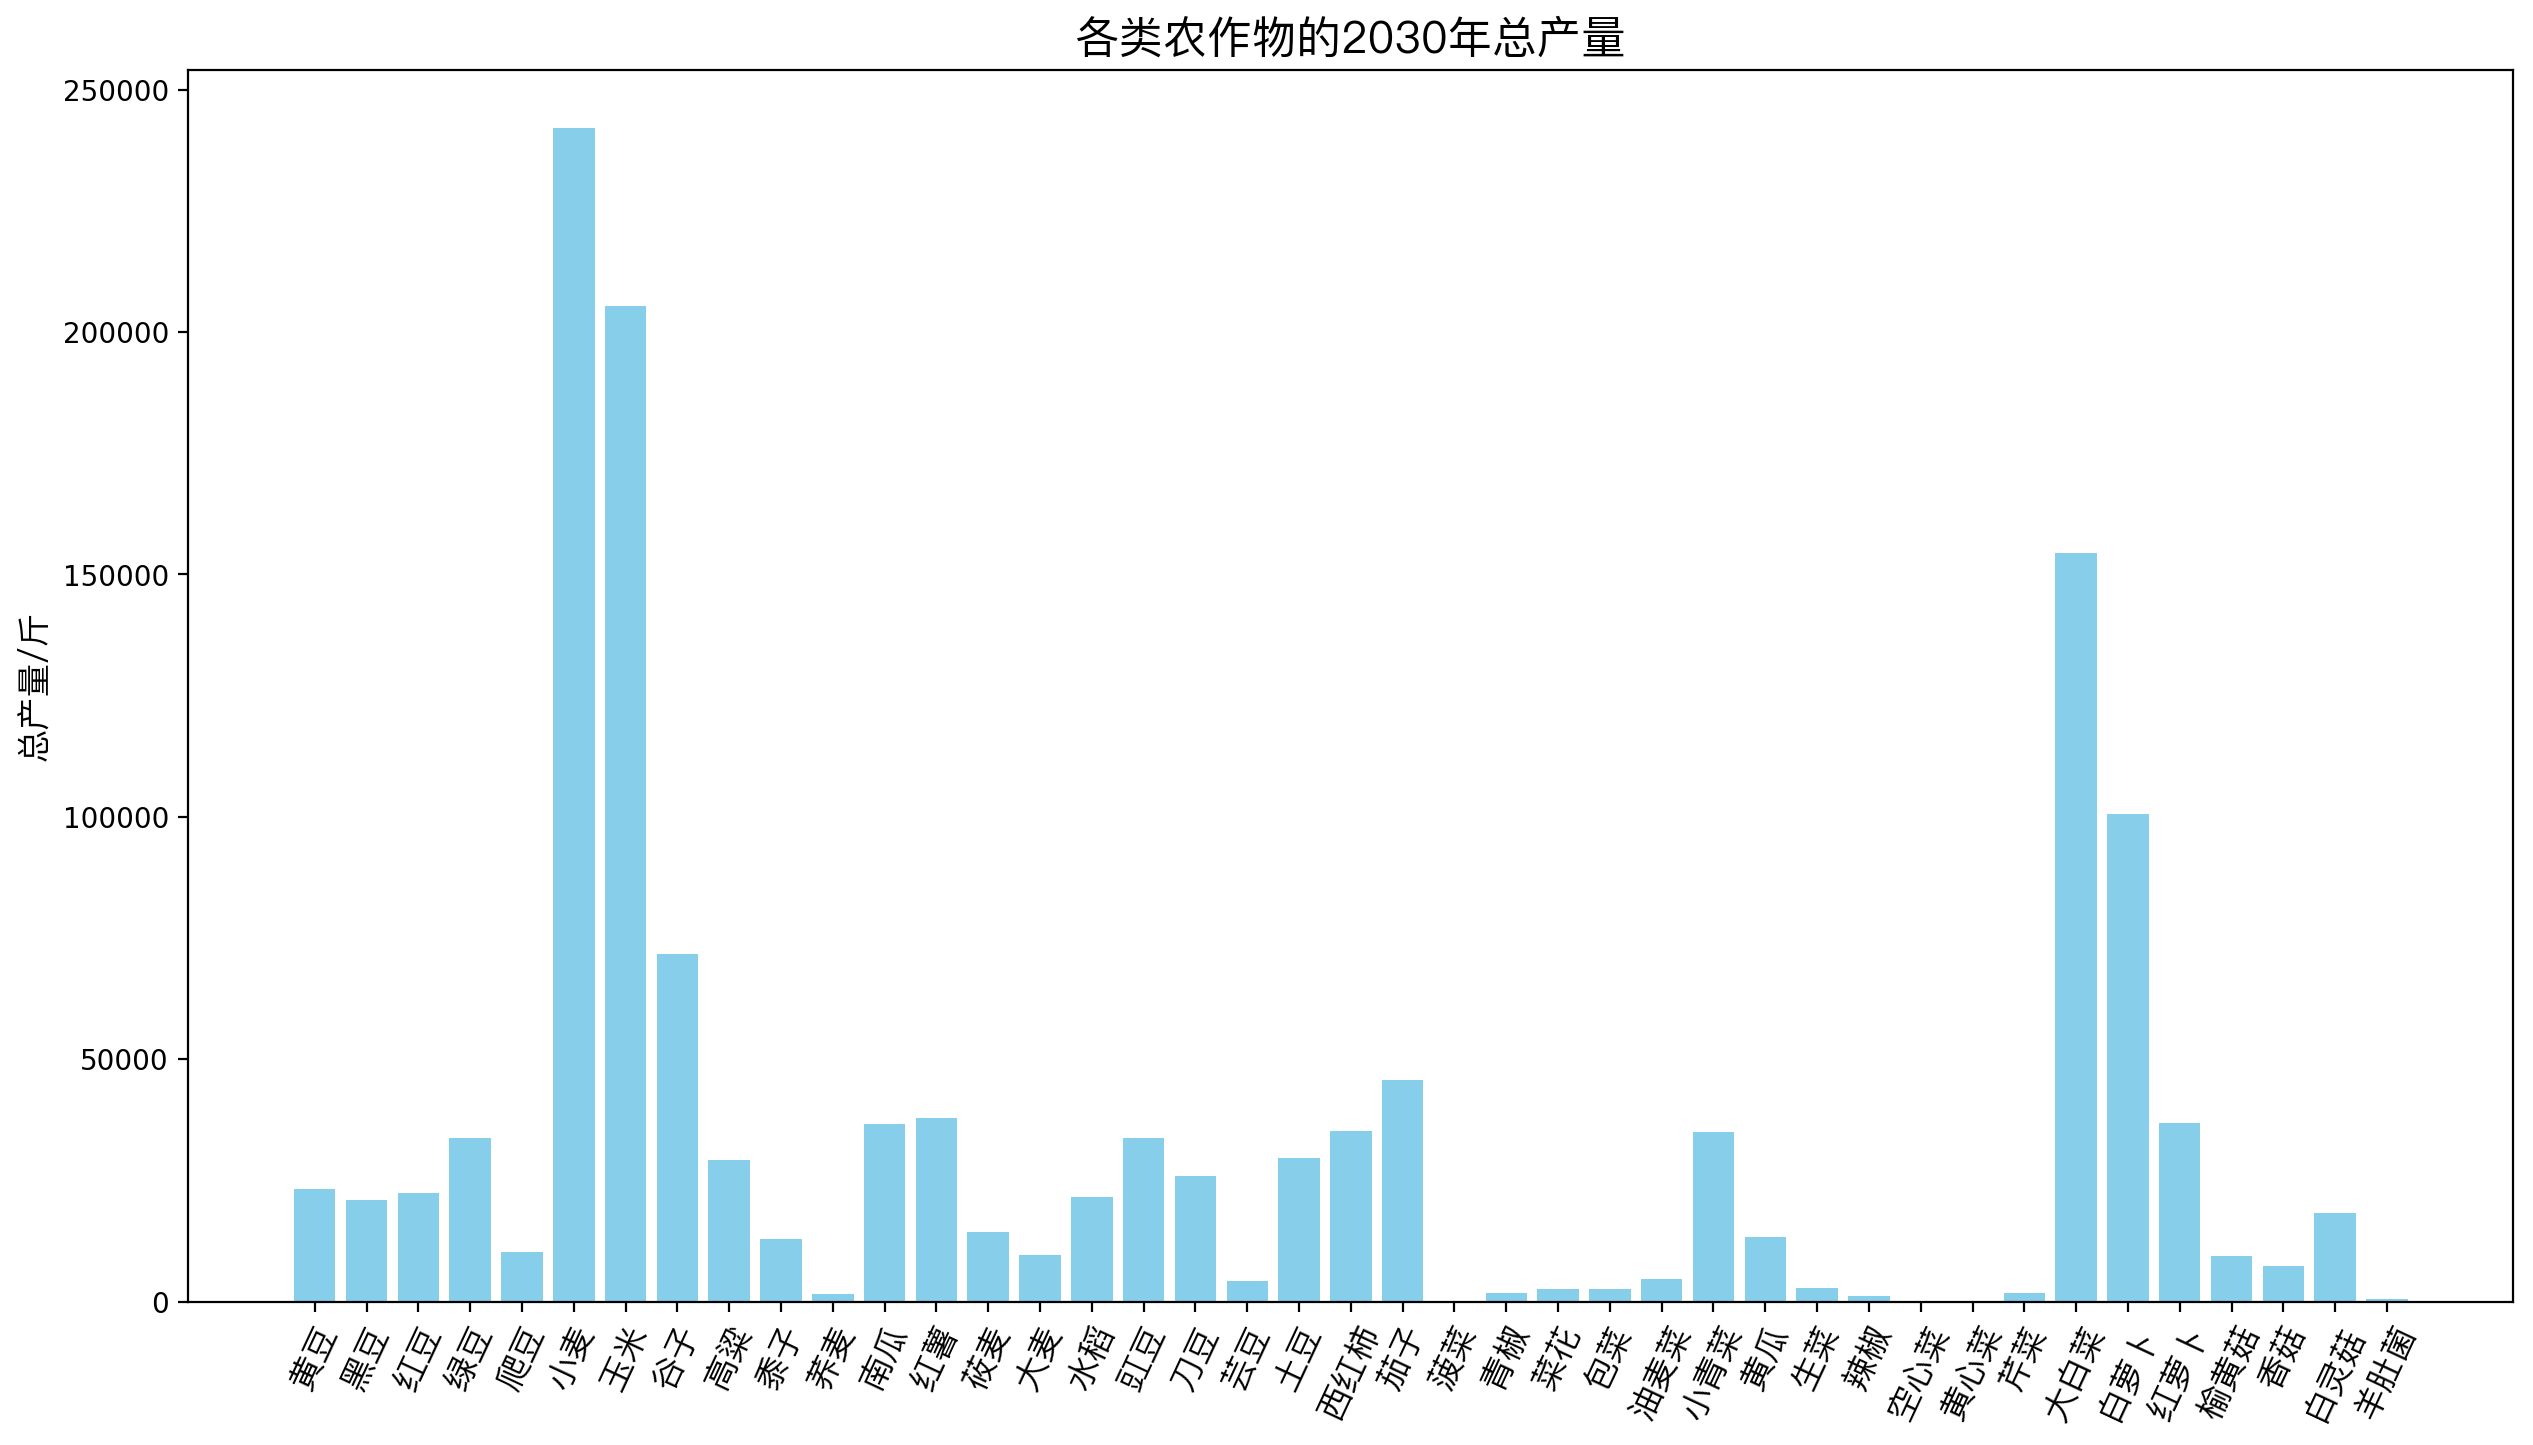

In [74]:
import matplotlib.pyplot as plt
import random
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter
import seaborn as sns



# 设置中文字体
font = FontProperties(fname='/System/Library/Fonts/PingFang.ttc')  # 指定字体路径
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# # 生成 54 行 41 列的二维列表
# rows = 54
# cols = 41
# data_list = [[random.uniform(0.6, 500) for _ in range(cols)] for _ in range(rows)]

# 获取 i, j, k 的最大索引值（假设字典中的索引是连续的）
Xcopy = X.copy()
i_max = max(Xcopy.keys()) + 1
j_max = max(max(Xcopy[i].keys()) for i in Xcopy) + 1
k_max = max(max(Xcopy[i][j].keys()) for i in X for j in Xcopy[i]) + 1

# 初始化三维 numpy 数组
X_out = np.zeros((i_max, j_max, k_max))

# 将字典中的值赋给对应的数组元素
for i in Xcopy:
    for j in Xcopy[i]:
        for k in Xcopy[i][j]:
            X_out[i, j, k] = Xcopy[i][j][k].varValue

# 打印结果
total_produce = X_out * q  # 总产量
q_print = total_produce[:, :, -2:]  # 选择第一季的亩产量
# 两季求和
q_print = q_print.sum(axis=-1)
q_print.shape
# 示例数据：假设 data_list 是你的 54 行 * 41 列的二维列表

# 计算每一列的总和
column_sums = [sum(row[i] for row in q_print) for i in range(len(q_print[0]))]

# 横坐标标签
labels = [
    '黄豆', '黑豆', '红豆', '绿豆', '爬豆', '小麦', '玉米', '谷子', '高粱', '黍子',
    '荞麦', '南瓜', '红薯', '莜麦', '大麦', '水稻', '豇豆', '刀豆', '芸豆', '土豆',
    '西红柿', '茄子', '菠菜', '青椒', '菜花', '包菜', '油麦菜', '小青菜', '黄瓜', 
    '生菜', '辣椒', '空心菜', '黄心菜', '芹菜', '大白菜', '白萝卜', '红萝卜', 
    '榆黄菇', '香菇', '白灵菇', '羊肚菌'
]
data_list = pd.DataFrame(column_sums, index=labels)
data_list.columns = ['总和']
# data_list.sort_values(by=['总和'], inplace=True, ascending=False)

# 创建直方图
plt.figure(figsize=(15, 8), dpi=200)
plt.bar(data_list.index, data_list['总和'], color='skyblue')

# 添加标题和标签
plt.title('各类农作物的2030年总产量', fontproperties=font, fontsize=16)
plt.ylabel('总产量/斤', fontproperties=font, fontsize=12)
plt.xticks(rotation=65, fontproperties=font, fontsize=12)
# plt.xticks(rotation=90)  # 旋转横坐标标签以便更好地显示

# 显示图形
plt.show()